In [1]:
import pandas as pd


I part 2 starter vi ud med at indlæse vores 'train_set.csv', 'validation_set.csv' og 'test_set.csv'

In [123]:
train_data = pd.read_csv('train_set.csv')
val_data = pd.read_csv('validation_set.csv')
test_data = pd.read_csv('test_set.csv')

################
# Task 0
################

Pålidelig Denne kategori omfatter nyhedskilder,(reliable og political) der betragtes som troværdige og upartiske.\
De leverer faktuel information og undgår at fremsætte udokumenterede påstande eller vildledende information.\
Falsk Denne kategori indeholder nyhedskilder, der anses for at være upålidelige og/eller partiske (fake,\
bias, conspiracy, hate, junksci, rumor, unreliable og satire). De kan sprede misinformation, propaganda eller\
konspirationsteorier.

Vi har derfor valgt typerne 'reliable og political' som værende reliable og resten fake.

####################
# Task 1
####################

Vi vil nu konvertere 'type' kolonnen til en binær klassificering, hvor 1 er lig med alle de reliable news og 0 er lig med alle de fake news. Samtidig med dette opretter vi en baseline model, som vi har valgt til at være naive bayes. 

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pandas as pd

train_data = pd.read_csv('train_set.csv')

train_data['stemmed_content'].fillna('', inplace=True)

reliable_categories = ['reliable', 'political']
fake_categories = ['fake', 'bias', 'conspiracy', 'hate', 'junksci', 'rumor', 'unreliable', 'satire']

def map_to_binary(article_type):
    if article_type in reliable_categories:
        return 1  
    elif article_type in fake_categories:
        return 0  
    else:
        return 0 

train_data['type'] = train_data['type'].apply(map_to_binary)

y_train = train_data['type']
X_train = train_data['stemmed_content']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)

val_data = pd.read_csv('validation_set.csv')
val_data['stemmed_content'].fillna('', inplace=True)

val_data['type'] = val_data['type'].apply(map_to_binary)

X_val = val_data['stemmed_content']
y_val = val_data['type']

y_pred = pipeline.predict(X_val)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy}")


Validation accuracy: 0.8293869346733669


Beregner også F1_Score

In [152]:
from sklearn.metrics import f1_score

f1 = f1_score(y_val, y_pred)

print(f"F1-Score: {f1:.4f}")


F1-Score: 0.9284


#############################
# Task 2
#############################

Iforhold til meta data overvejede vi domain men i og med vi tidligere fandt ud af at hver domain kun udgiver 1 type artikel mener vi at det vil "overfitte" vores model, hvor vores model bare genkender domain istedet for at forudsige. Vi valgte derfor i stedet at prøve med authors og for at om dette spillede nogen rolle. Det viser sig at accuracy stiger med ca. 10%, med author som meta-feature rammer vi nu en accuracy på 92,2 %. 

In [127]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

train_data = pd.read_csv('train_set.csv')
train_data['stemmed_content'].fillna('', inplace=True)
train_data['authors'].fillna('', inplace=True)

val_data = pd.read_csv('validation_set.csv')
val_data['stemmed_content'].fillna('', inplace=True)
val_data['authors'].fillna('', inplace=True)

train_data['type'] = train_data['type'].apply(map_to_binary)
val_data['type'] = val_data['type'].apply(map_to_binary)

X_train = train_data[['stemmed_content', 'authors']]
y_train = train_data['type']
X_val = val_data[['stemmed_content', 'authors']]
y_val = val_data['type']

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'stemmed_content'),
        ('authors', OneHotEncoder(handle_unknown='ignore'), ['authors'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy}")

f1 = f1_score(y_val, y_pred)
print(f"F1-Score: {f1:.4f}")

Validation accuracy: 0.9220603015075377
F1-Score: 0.8994


######################
# task 3
######################

Jeg starter med at indlæse filen fra exercise 2 - scraped_articles.csv

In [134]:
scraped_articles = pd.read_csv('scraped_articles.csv')

Da disse artikler ikke er blevet renset eller lavet stemming på endnu, vil vi starte med at gøre dette:

In [135]:
import pandas as pd
import re

def clean_text(text):
    if pd.isna(text):  
        return ''
    text = str(text).lower() 
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', '<DATE>', text)  
    text = re.sub(r'\d+', '<NUM>', text)  
    text = re.sub(r'\S+@\S+', '<EMAIL>', text)  
    text = re.sub(r'https?://\S+', '<URL>', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    return text

csv_file_path = 'scraped_articles.csv'  

scraped_articles = pd.read_csv(csv_file_path, dtype=str)

scraped_articles['cleaned_text'] = scraped_articles['text'].apply(clean_text)

cleaned_scraped_articles = scraped_articles[['cleaned_text']]

cleaned_scraped_articles.head


<bound method NDFrame.head of                                            cleaned_text
0     we know whats coming east ukraine braces for r...
1     in eastern ukraine the tide of this war hasnt ...
2     in order to preserve life and encirclement i h...
3     fighting has been raging in ukraine for two ye...
4     deadly explosions have rocked ukraines souther...
...                                                 ...
5762  indias capital delhi has banned motorbike taxi...
5763  two years ago indian prime minister narendra m...
5764  the discovery of two charred bodies in a burnt...
5765  the judges of masterchef india have been criti...
5766  ruchelle barrie remembers feeling out of place...

[5767 rows x 1 columns]>

In [136]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def remove_stopwords_and_stem(text):
    words = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words if word not in stop_words])

cleaned_scraped_articles.loc[:, 'stemmed_content'] = cleaned_scraped_articles['cleaned_text'].apply(remove_stopwords_and_stem)

cleaned_scraped_articles.head()



[nltk_data] Downloading package punkt to /Users/bruger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bruger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/78/tggs5x_100l2bhsl5ydp24mh0000gn/T/ipykernel_38027/3327478432.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_scraped_articles.loc[:, 'stemmed_content'] = cleaned_scraped_articles['cleaned_text'].apply(remove_stopwords_and_stem)


,cleaned_text,stemmed_content
0,we know whats coming east ukraine braces for r...,know what come east ukrain brace russian advan...
1,in eastern ukraine the tide of this war hasnt ...,eastern ukrain tide war hasnt chang come fast ...
2,in order to preserve life and encirclement i h...,order preserv life encircl withdrawn unit avdi...
3,fighting has been raging in ukraine for two ye...,fight rage ukrain two year sinc russia invas m...
4,deadly explosions have rocked ukraines souther...,deadli explos rock ukrain southern port citi o...


Nu har vi altså renset og stemmed vores scraped_articles.csv og lavet en ny kolonne i dataen, som hedder cleaned_stemmed_text. Det næste vi vil gøre er at oprette en kolonne 'type' som fortæller om artiklen er reliable eller fake. Her vil vi vurdere alle artiklerne til at være reliable, da de kommer fra bbc. Dette vil altså sige at der kommer til at stå et 1 til under 'type' for alle artiklerne, da det betyder reliable i vores binære klassificering. 

In [131]:
cleaned_scraped_articles['type'] = 1

cleaned_scraped_articles.to_csv('cleaned_scraped_articled')

cleaned_scraped_articles



/var/folders/78/tggs5x_100l2bhsl5ydp24mh0000gn/T/ipykernel_38027/2909232008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_scraped_articles['type'] = 1


,cleaned_text,stemmed_content,type
0,we know whats coming east ukraine braces for r...,know what come east ukrain brace russian advan...,1
1,in eastern ukraine the tide of this war hasnt ...,eastern ukrain tide war hasnt chang come fast ...,1
2,in order to preserve life and encirclement i h...,order preserv life encircl withdrawn unit avdi...,1
3,fighting has been raging in ukraine for two ye...,fight rage ukrain two year sinc russia invas m...,1
4,deadly explosions have rocked ukraines souther...,deadli explos rock ukrain southern port citi o...,1
...,...,...,...
5762,indias capital delhi has banned motorbike taxi...,india capit delhi ban motorbik taxi road deal ...,1
5763,two years ago indian prime minister narendra m...,two year ago indian prime minist narendra modi...,1
5764,the discovery of two charred bodies in a burnt...,discoveri two char bodi burnt vehicl india har...,1
5765,the judges of masterchef india have been criti...,judg masterchef india criticis social media le...,1


Nu hvor vi har en kolonne med stemmed_content hvor alle er sat til reliable under type, vil vi sammensætte vores train_data og cleaned_scraped_articles. 

In [132]:
train_scraped_combined = pd.concat([train_data, cleaned_scraped_articles], ignore_index=True)

train_scraped_combined.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,tokens,stemmed_content,cleaned_text
0,NUM,NUMNUM,abovetopsecretcom,0,URL,geoengineering cost analysis you lolyes seen ...,NUMNUMNUMtNUMNUMNUMNUM,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,possible weather mod setup page NUM,,NaN,NaN,NaN,NaN,NaN,NaN,geoengineering cost analysis lolyes seen docum...,geoengin cost analysi loly seen documentwhat t...,NaN
1,NUM,NUMNUM,thelibertybeaconcom,0,URL,lawNUM philadelphia february NUM NUM NUMNUM pm...,NUMNUMNUMtNUMNUMNUMNUM,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,merck sued in philly over shingles vaccine inj...,,NaN,NaN,NaN,natural immunity chickenpox merck lawsuit vacc...,NaN,NaN,lawNUM philadelphia february NUM NUM NUMNUM pm...,lawnum philadelphia februari num num numnum pm...,NaN
2,NUM,NUM,newswithviewscom,0,URL,additional titles our right to attack iraq by ...,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,devvy kidd new gun bill in congress more unco...,,NaN,NaN,NaN,NaN,NaN,NaN,additional titles right attack iraq devvy kidd...,addit titl right attack iraq devvi kidd februa...,NaN
3,NUM,NUM,nytimescom,1,URL,i dont know who takes him said an eastern conf...,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,multiple nicknames dwindling openings,howard beck,NaN,oneal shaquille basketball free agents sports ...,shaquille oneal who once rumbled across the co...,NaN,NaN,nytimes,dont know takes said eastern conference scout ...,dont know take said eastern confer scout cite ...,NaN
4,NUM,NUM,nationalreviewcom,1,URL,plus one article on google plus thanks to ali ...,NUMNUMNUMtNUMNUMNUMNUM,DATE NUMNUMNUMNUM,DATE NUMNUMNUMNUM,iran news round up,,NaN,national review national review online article,NaN,NaN,NaN,NaN,plus one article google plus thanks ali alfone...,plu one articl googl plu thank ali alfoneh ass...,NaN


In [137]:
train_scraped_combined.to_csv('train_scraped_combined.csv', index=False)


Nu prøver vi at bruge vores simple baseline "naive bayes" og ser om de 5767 ekstra artikler kan øge præcisionen.

In [153]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

X_val = val_data['stemmed_content']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.fit(train_scraped_combined['stemmed_content'], train_scraped_combined['type'])

y_pred = pipeline.predict(X_val)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with additional reliable data: {val_accuracy}")

Validation accuracy with additional reliable data: 0.8320904522613065


Som vi kan se på resultatet er nøjagtigheden blevet øget med ca. 0,3% hvilket giver god mening efter som vi har tilføjet 5767 artikler til train_data som i forvejen bestod af 796000 artikler. Da det kun er 5767 artikler vi har tilføjet til train_data havde vi også forventet en meget lille forbedring i nøjagtigheden. Vi har altså kun øget træningssættet med 0,72% og dermed skulle det ikke forbedre nøjagtigheden vildt meget. Ud fra dette resultat, har vi besluttet os for ikke at arbejde videre med dette datasæt, da forøgelsen af nøjagtighed er så lille. Men ud fra resultatet, kan man konkluderer at mere data at træne modellen med er lig med bedre nøjagtighed. 

#####################
# Part 3
#####################

Bruger vores advanced model her, som resulterede i en logistic regression, hvor vi har tilføjet authors som meta-feature.

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


train_data = pd.read_csv('train_set.csv')
val_data = pd.read_csv('validation_set.csv')

train_data['stemmed_content'].fillna('', inplace=True)
train_data['authors'].fillna('', inplace=True)
val_data['stemmed_content'].fillna('', inplace=True)
val_data['authors'].fillna('', inplace=True)


y_train = train_data['type'].apply(map_to_binary)
y_val = val_data['type'].apply(map_to_binary)

X_train = train_data[['stemmed_content', 'authors']]
X_val = val_data[['stemmed_content', 'authors']]

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'stemmed_content'),
        ('authors', OneHotEncoder(handle_unknown='ignore'), ['authors'])
    ]
)

advanced_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

advanced_pipeline.fit(X_train, y_train)

y_pred = advanced_pipeline.predict(X_val)

val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy}")

y_pred_probs = advanced_pipeline.predict_proba(X_val)[:, 1]
mse_logistic = mean_squared_error(y_val, y_pred_probs)
print(f"LogisticRegression MSE: {mse_logistic}")
f1 = f1_score(y_val, y_pred)
print(f"F1-Score: {f1:.4f}")

Validation accuracy: 0.9423316582914573
LogisticRegression MSE: 0.043330744473855855
F1-Score: 0.9284


#################
# Part 4
#################

################
# Task 1
################

Her prøver vi at køre vores advanced pipeline på test sættet som modellen altså ikke er trænet på i forvejen. Resultatet viser os at den næsten fungerer ligeså godt som den gjorde på vores validation sæt, som den allerede var trænet på, hvilket tyder på at modellen virker rigtig godt. Det er et godt resultat, da formålet er at den skal kunne virke godt på ukendte artikler og kunne vurdere dem til enten fake eller reliable. 

In [18]:
test_data = pd.read_csv('test_set.csv')
test_data['stemmed_content'].fillna('', inplace=True)
test_data['authors'].fillna('', inplace=True)
test_data['type'] = test_data['type'].apply(map_to_binary)

X_test = test_data[['stemmed_content', 'authors']]
y_test = test_data['type']

y_pred_test = advanced_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy: {test_accuracy}")
f1 = f1_score(y_test, y_pred_test,)
print(f"F1-score: {f1}")

y_pred_probs_test = advanced_pipeline.predict_proba(X_test)[:, 1]
mse_logistic = mean_squared_error(y_test, y_pred_test)
print(f"LogisticRegression MSE: {mse_logistic}")

Test accuracy: 0.9405929648241206
F1-score: 0.9261300441145228
LogisticRegression MSE: 0.0594070351758794


In [19]:
y_pred_test = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy: {test_accuracy}")
f1 = f1_score(y_test, y_pred_test,) 
print(f"F1-score: {f1}")

Test accuracy: 0.9206130653266331
F1-score: 0.8974834849645041


Vi opdager lidt samme resultat med vores baseline model, her ser vi altså resultatet er ret højt, hvilket er fordi vi har authors tilføjet som meta-festure her også. Vores forrige resultat fra vores baseline model med authors som meta-feature på vores validition sæt var: Validation accuracy: 0.9220603015075377
F1-Score: 0.8994 hvilket er meget tæt på dette resultatet, men stadig en lille smule bedre.

###############
# Task 2
###############

Vi starter ud med at indlæse de 3 datasæt som vi skal arbejde med her, altså: train.tsv, valid.tsv og test.tsv.

In [103]:
train_data_liar = pd.read_csv('train.tsv', sep='\t')
valid_data_liar = pd.read_csv('valid.tsv', sep='\t')
test_data_liar = pd.read_csv('test.tsv', sep='\t')

In [104]:
train_data_liar.head()

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


Som jeg kan se på det indlæste datasæt har kolonnerne ikke nogle navne, derfor vil vi starte med at navngivne dem ud fra hvad Readme siger at hver kolonne angiver. Vi antager dog at "Label" kolonnen svarer til "Type" kolonnen i FakeNewsCorpus og derfor kalder vi denne for "type" i stedet for "Label", derudover ligger vi mærke til at speaker også skal ændres til authors for at matche FakeNewsCorpus. Da der ikke er nogen direkte 'content' kolonne, vil jeg bruge 'statement' som 'content', så der også er noget der matcher 'content' kolonnen fra FakeNewsCorpus. Derudover husker vi at vores model er trænet på en kolonne 'stemmed_content' og derfor vælger vi at kalde content kolonnen 'stemmed_content' selvom den ikke er stemmed, dette gør vi for at sikre os at vores model virker. 

In [109]:
column_names = [
    'ID', 'type', 'stemmed_content', 'subjects', 'authors',
    'speaker\'s Job Title', 'state Info', 'party Affiliation',
    'barely True Counts', 'false Counts', 'half True Counts',
    'mostly True Counts', 'pants on Fire Counts', 'context'
]

train_data_liar = pd.read_csv('train.tsv', delimiter='\t', header=None, names=column_names)
valid_data_liar = pd.read_csv('valid.tsv', delimiter='\t', header=None, names=column_names)
test_data_liar = pd.read_csv('test.tsv', delimiter='\t', header=None, names=column_names)

train_data_liar.head()


,ID,type,stemmed_content,subjects,authors,speaker's Job Title,state Info,party Affiliation,barely True Counts,false Counts,half True Counts,mostly True Counts,pants on Fire Counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


Da vores model fra FakeNewsCorpus er trænet på en binær klassificering under 'type', vil vi her starte med at gøre 'type' kolonnen for vores Liar datasæt til en binær klassificering, hvor 1 = true og 0 = false. 

In [110]:
unique_types = train_data_liar['type'].unique()
print(unique_types)

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


Når vi kigger på værdierne under 'type' kolonnenn, vælger vi at klassificere 'true' og 'mostly-true' som reliable og resten som fake. 

In [111]:
def label_to_binary(label):
    if label in ['true', 'mostly-true']:
        return 1 
    else:
        return 0 

train_data_liar['type'] = train_data_liar['type'].apply(label_to_binary)
valid_data_liar['type'] = valid_data_liar['type'].apply(label_to_binary)
test_data_liar['type'] = test_data_liar['type'].apply(label_to_binary)

print(train_data_liar['type'].value_counts())
print(valid_data_liar['type'].value_counts())
print(test_data_liar['type'].value_counts())


type
0    6602
1    3638
Name: count, dtype: int64
type
0    864
1    420
Name: count, dtype: int64
type
0    818
1    449
Name: count, dtype: int64


In [117]:
X_test_liar = test_data_liar[['stemmed_content', 'authors']]
y_test_liar = test_data_liar['type']

y_pred_test_liar = pipeline.predict(X_test_liar)
test_accuracy_liar = accuracy_score(y_test_liar, y_pred_test_liar)
print(f"Test accuracy on LIAR dataset with simple model: {test_accuracy_liar}")

f1_liar_baseline = f1_score(y_test_liar, y_pred_test_liar,)
print(f"F1-score: {f1_liar_baseline}")


Test accuracy on LIAR dataset with simple model: 0.6314127861089187
F1-score: 0.15855855855855855


In [118]:
X_test_liar_advanved = test_data_liar[['stemmed_content', 'authors']]
y_test_liar_advanced = test_data_liar['type']

y_pred_test_liar_advanced = advanced_pipeline.predict(X_test_liar)
test_accuracy_liar = accuracy_score(y_test_liar, y_pred_test_liar_advanced)
print(f"Test accuracy on LIAR dataset with advanced model: {test_accuracy_liar}")

f1_liar_advanced = f1_score(y_test_liar, y_pred_test_liar_advanced,) 
print(f"F1-score: {f1_liar_advanced}")

mse_logistic_liar = mean_squared_error(y_test_liar, y_pred_test_liar_advanced)
print(f"LogisticRegression MSE: {mse_logistic}")

Test accuracy on LIAR dataset with advanced model: 0.6243093922651933
F1-score: 0.047999999999999994
LogisticRegression MSE: 0.0594070351758794


FakeNewsCorpus resultater på test sæt:
╒════════════════╤══════════╤═════════════════╤════════════╕
│ Dataset        │ Model    │   Test accuracy │   F1-score │
╞════════════════╪══════════╪═════════════════╪════════════╡
│ FakeNewsCorpus │ Advanced │        0.940593 │   0.92613  │
├────────────────┼──────────┼─────────────────┼────────────┤
│ FakeNewsCorpus │ Baseline │        0.829386 │   0.897483 │
├────────────────┼──────────┼─────────────────┼────────────┤
│ LIAR           │ Advanced │        0.624309 │   0.048    │
├────────────────┼──────────┼─────────────────┼────────────┤
│ LIAR           │ Baseline │        0.631413 │   0.158559 │
╘════════════════╧══════════╧═════════════════╧════════════╛

FakeNewsCorpus forbedring ved brug af advanced model:
╒════════════════╤══════════╤═════════════════╤════════════╕
│ Dataset        │ Model    │   Test accuracy │   F1-score │
╞════════════════╪══════════╪═════════════════╪════════════╡
│ FakeNewsCorpus │ Advanced │        0.111207 │   0.

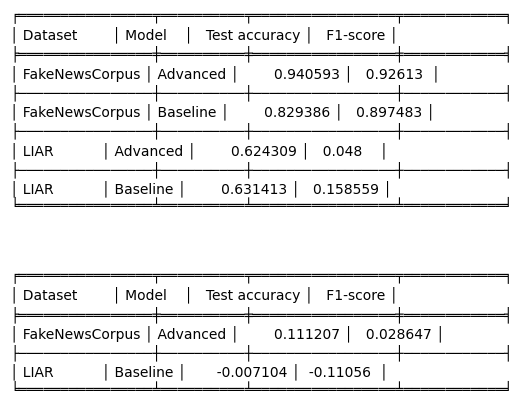

In [122]:
import matplotlib.pyplot as plt
from tabulate import tabulate

results = {
    'Dataset': ['FakeNewsCorpus', 'FakeNewsCorpus', 'LIAR', 'LIAR'],
    'Model': ['Advanced', 'Baseline', 'Advanced', 'Baseline'],
    'Test accuracy': [0.9405929648241206, 0.829386, 0.6243093922651933, 0.6314127861089187],
    'F1-score': [0.9261300441145228, 0.8974834849645041, 0.047999999999999994, 0.15855855855855855]
}

new_results = {
    'Dataset': ['FakeNewsCorpus', 'LIAR'],
    'Model': ['Advanced', 'Baseline'],
    'Test accuracy': [0.940593 - 0.829386, 0.624309 - 0.631413],
    'F1-score': [0.926130 - 0.897483, 0.047999 - 0.158559]
}

table1 = tabulate(results, headers='keys', tablefmt='fancy_grid', showindex=False)
table2 = tabulate(new_results, headers='keys', tablefmt='fancy_grid', showindex=False)

print("FakeNewsCorpus resultater på test sæt:")
print(table1)
print("\nFakeNewsCorpus forbedring ved brug af advanced model:")
print(table2)

fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)
axs[0].axis('off')
axs[0].text(0, 0.5, table1, fontsize=10, verticalalignment='center')
axs[1].axis('off')
axs[1].text(0, 0.5, table2, fontsize=10, verticalalignment='center')
plt.show()

